# ALS Project - Modeling

### Random Forest Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

In [150]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from regress_model import Linear_Model
from linear_plotting import *
from sklearn.cluster import KMeans
import rfpimp 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def plot_model_parallel(y_test, y_predicted, units='units'):
    data = pd.DataFrame(y_test.values, columns=["test"])
    data['predicted']=y_predicted
    data['result']='result'
    parallel_coordinates(data, 'result',colormap=plt.get_cmap("Set2"), alpha=0.6)
    plt.title("Results of Model")
    plt.ylabel(units)
    plt.show()

In [5]:
def plot_predicted_regression(predicted, actual, suptitle='Regression', title=""):
    plt.plot(predicted, actual, '*')
    plt.suptitle(suptitle)
    plt.title(title)
    plt.ylabel("actual")
    plt.xlabel("predicted")
    plt.xlim(0, 2500)
    plt.ylim(0, 2500)
    plt.plot([0,2500], [0,2500])
    plt.show()

In [6]:
def plot_roc(model, X_test, y_test, model_type='forest', target='Target'):
    '''
    plot a ROC curve for a model or lists of models
    '''
    # note: kNN does not plot an roc curve using a decision function...not 
    model_list = [1]
    n_classes = len(model_list)
    y_dec = model.predict_proba(X_test)
    if y_dec.ndim == 1:
        y_dec = np.array(y_dec).reshape(-1,1)
    if y_test.ndim == 1:
        y_test = np.array(y_test).reshape(-1,1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    plt.figure()
    lw = 2

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_dec[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color='darkorange',
            lw=lw, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if model_type == 'adaboost':
        plt.title('ROC: {}  | {}, LR={}, N_Est={} |'.format(model_type, model.get_params()['algorithm'], model.get_params()['learning_rate'], model.get_params()['n_estimators']))
    elif model_type == 'gradient':
        plt.title('ROC: {}  | {}, LR={}, N_Est={} |'.format(model_type, model.get_params()['criterion'], model.get_params()['learning_rate'], model.get_params()['n_estimators']))
    elif model_type == 'forest':
        plt.title('ROC: {}  |  Citerion={}, N_Est={} |'.format(model_type, model.get_params()['criterion'], model.get_params()['n_estimators']))
    else:
        plt.title('ROC: {}  |  |'.format(model_type))
    plt.suptitle(target)
    plt.legend(loc="lower right")
    plt.show()


In [131]:
def confusion_table(model, X_test, y_test):
    # Compute confusion matrix - uses confusion matrix from y_true and y_predicted
    print("** Confusion Matrix **")
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    header = [np.array(['Actual','Actual']), np.array(['True','False'])] 
    indexer = [np.array(['Predicted','Predicted']), np.array(['True','False'])] 
    df = pd.DataFrame([[tp,fp], [fn, tn]], columns = header, index = indexer)
    print(df)
    #return df

In [8]:
def feature_import(model, X_test, y_test):
    '''
    determine relative feature importance in model using permuation importance
    '''
    # permutation importances returns a df with feature, importance columns
    colnames = X_test.columns
    X_test_df = pd.DataFrame(X_test)
    y_test_df = pd.DataFrame(y_test)
    imp = rfpimp.importances(model, X_test_df, y_test_df, colnames)
    viz = rfpimp.plot_importances(imp)
    print("Permutation Feature Importance")
    viz.view()

In [140]:
def run_rf(df, features, class_regress, target, limit_on, exclude_columns=None):
    '''
    run a random forest model - classifier or regressor
    input:
        df = df
        features = list of strings. list of features to include in model (should contain the target)
        target = string. column name of target variable
        limit_on = string. column values should be boolean
        exclude_columns = leave this feature out of analysis.
    output:
        model outputs
    '''
    ### prepare input
    model_data = df[features].copy()
    model_data.dropna(inplace=True)
    model_data.reset_index(drop=True, inplace=True)
    
    # limit data to only subjects with value = target
    if limit_on != None:
        limited_model_data = model_data[ model_data[limit_on]==1].copy()

        # assign target, features
        y = limited_model_data[target]
        X = limited_model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    else:
        # assign target, features
        y = model_data[target]
        X = model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=1234)
    
    ### Fit model
    if class_regress == 'classifier':
        # run classiffier RF model
        model = RandomForestClassifier(n_estimators=10)
        model.fit(X_train,y_train)
    else:
        model = RandomForestRegressor(n_estimators=10)
        model.fit(X_train,y_train)
    

    ### Output
    # predicted values
    if class_regress == 'classiffier':
        # classiffier
        y_predicted = model.predict_proba(X_test)
       
    else:
        # regression
        y_predicted = model.predict(X_test)
    
    compare_data = pd.DataFrame(y_test.values, columns=["test"])
    compare_data['predicted']=y_predicted
    compare_data['result']='result'
    
    print("** Comparison Data **")
    print("Number of training observations: {}".format(len(X_train)))
    print("Number of test observations: {}".format(compare_data.shape[0]))
    print(compare_data.head())
    print("")
    
    # score - R2 for regress, accuracy for class
    print("Accuracy/R2 Score: {}".format(model.score(X_test, y_test.values)))
    if class_regress == 'classifier':
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print("Cross Val Scores: {}".format(scores))
        print("Mean Cross Val Score: {}".format(np.mean(scores)))

    # print confusion table
    if class_regress == 'classifier':
        confusion_table(model, X_test, y_test)

        #print f1 score
        f_1_score = f1_score(y_test, model.predict(X_test))
        print("")
        print("** F1 Score **")
        print("F1 = 2 * (precision * recall) / (precision + recall)")
        print("F1 Score: {}%".format(round(f_1_score*100,2)))

        # plot ROC
        plot_roc(model, X_test, y_test, model_type='forest', target=target)

    else:
        if limit_on==None:
            title = ""
        else:
            title = "Limit On: " + limit_on
        plot_predicted_regression(compare_data['predicted'], 
                                  compare_data['test'], 
                                  suptitle= "Target: "+target, 
                                  title=title)
        # plot parallels
        plot_model_parallel(y_test, y_predicted, units='units')
    
    # plot feature importances
    feature_import(model, X_test, y_test)

In [154]:
def run_gboost(df, features, class_regress, target, limit_on, exclude_columns=None, params=None):
    '''
    run a gboost model - classifier or regressor
    input:
        df = df
        features = list of strings. list of features to include in model (should contain the target)
        target = string. column name of target variable
        limit_on = string. column values should be boolean
        exclude_columns = leave this feature out of analysis.
    output:
        model outputs
    
    regressor defauts:
    params = { 'loss':'ls', 'learning_rate':0.1, 'n_estimators':100, 
                'subsample':1.0, 'criterion':'friedman_mse', 'min_samples_split':2, 
                'min_samples_leaf':1, 'min_weight_fraction_leaf':0.0, 'max_depth':3, 
                'min_impurity_decrease':0.0, 'min_impurity_split':None, 'init':None, 
                'random_state':None, 'max_features'=None, 'alpha':0.9, 'verbose':0, 
                'max_leaf_nodes':None, 'warm_start':False, 'presort':'auto', 
                'validation_fraction':0.1, 'n_iter_no_change':None, 'tol':0.0001 }
    '''
    ### prepare input
    model_data = df[features].copy()
    model_data.dropna(inplace=True)
    model_data.reset_index(drop=True, inplace=True)
    
    # limit data to only subjects with value = target
    if limit_on != None:
        limited_model_data = model_data[ model_data[limit_on]==1].copy()

        # assign target, features
        y = limited_model_data[target]
        X = limited_model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    else:
        # assign target, features
        y = model_data[target]
        X = model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=1234)
    
    ### Fit model
    if class_regress == 'classifier':
        # run classiffier RF model
        model = RandomForestClassifier(n_estimators=10)
        model.fit(X_train,y_train)
    else:
        model = GradientBoostingRegressor(**params)
        model.fit(X_train,y_train)
    
    ### Output
    # predicted values
    if class_regress == 'classiffier':
        # classiffier
        y_predicted = model.predict_proba(X_test)
       
    else:
        # regression
        y_predicted = model.predict(X_test)
    
    compare_data = pd.DataFrame(y_test.values, columns=["test"])
    compare_data['predicted']=y_predicted
    compare_data['result']='result'
    
    print("** Comparison Data **")
    print("Number of training observations: {}".format(len(X_train)))
    print("Number of test observations: {}".format(compare_data.shape[0]))
    print(compare_data.head())
    print("")
    
    # score - R2 for regress, accuracy for class
    print("Accuracy/R2 Score: {}".format(model.score(X_test, y_test.values)))
    
    if class_regress == 'classifier':
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print("Cross Val Scores: {}".format(scores))
        print("Mean Cross Val Score: {}".format(np.mean(scores)))

    # print confusion table
    if class_regress == 'classifier':
        confusion_table(model, X_test, y_test)

        #print f1 score
        f_1_score = f1_score(y_test, model.predict(X_test))
        print("")
        print("** F1 Score **")
        print("F1 = 2 * (precision * recall) / (precision + recall)")
        print("F1 Score: {}%".format(round(f_1_score*100,2)))

        # plot ROC
        plot_roc(model, X_test, y_test, model_type='forest', target=target)

    else:
        if limit_on==None:
            title = ""
        else:
            title = "Limit On: " + limit_on
        if param_grid!=None:
            plot_predicted_regression(compare_data['predicted'], 
                                  compare_data['test'], 
                                  suptitle= "Target: "+target, 
                                  title=title)
        # plot parallels
        plot_model_parallel(y_test, y_predicted, units='units')
    
    # plot feature importances
    feature_import(model, X_test, y_test)

In [170]:
def run_cv_gboost(df, features, class_regress, target, limit_on, exclude_columns, param_grid):
    ### prepare input
    model_data = df[features].copy()
    model_data.dropna(inplace=True)
    model_data.reset_index(drop=True, inplace=True)
    
    # limit data to only subjects with value = target
    if limit_on != None:
        limited_model_data = model_data[ model_data[limit_on]==1].copy()

        # assign target, features
        y = limited_model_data[target]
        X = limited_model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    else:
        # assign target, features
        y = model_data[target]
        X = model_data.drop(target, axis=1)
        if exclude_columns!=None:
            X.drop(exclude_columns, axis=1, inplace=True)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        random_state=1234)
    
    model = GradientBoostingRegressor()
    grid = GridSearchCV(estimator = model, param_grid = param_grid, 
                      cv = 3, n_jobs = 4, verbose = 2)
    grid.fit(X_train, y_train)
    
    print(grid.best_params_)

### data = txt, death, riluzole, onset dates, demo

In [10]:
# load data
df = pd.read_csv("clean_data/tdrod.csv")
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(9640, 20)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,death_month,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Caucasian,Race_Other,sex,age_trial_start_days,age_at_onset
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1.0,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0.0,13870.0,42.673973
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0.0,18980.0,53.372603
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1.0,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1.0,NaN,NaN


### Add functional scale linear slopes

In [11]:
scale_assess = pd.read_csv("clean_data/scale_assess_slope.csv")
print(scale_assess.shape)
scale_assess.head()

(6537, 4)


,subject_id,scale,slope,intercept
0,329,original,-0.007092,40.084327
1,348,revised,-0.012720,46.428161
2,533,revised,-0.010940,48.231426
3,586,revised,-0.012535,48.000000
4,649,original,-0.020465,43.366399


In [12]:
# merge with previous data
df = df.merge(scale_assess, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10325, 23)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Caucasian,Race_Other,sex,age_trial_start_days,age_at_onset,scale,slope,intercept
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,13870.0,42.673973,original,-0.007092,40.084327
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,18980.0,53.372603,revised,-0.012720,46.428161
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN


## Add the onset symptom data

In [13]:
symptom = pd.read_csv("clean_data/symptom_onset.csv")
print(symptom.shape)
symptom.head()

(2219, 29)


,subject_id,right_side,left_side,bilateral_side,loc_general,loc_trunk,loc_face,loc_mouth,loc_speech,loc_speech_or_mouth,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,649,0,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
1,1234,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
2,2540,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2956,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3085,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0


In [14]:
# merge with previous data
df = df.merge(symptom, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10334, 51)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,symptom_atrophy,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add individual question data

In [15]:
scores = pd.read_csv("clean_data/scores_delta.csv")
print(scores.shape)
scores.head()

(6683, 16)


,subject_id,day_since_onset,time_delta_Q1_Speech,time_delta_Q2_Salivation,time_delta_Q3_Swallowing,time_delta_Q4_Handwriting,time_delta_Q5a_Cutting_without_Gastrostomy,time_delta_Q5b_Cutting_with_Gastrostomy,time_delta_Q6_Dressing_and_Hygiene,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency
0,329,1980.0,0.000000,0.000505,0.000000,0.000505,0.001515,NaN,0.001010,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN
1,348,902.0,0.000000,0.000000,0.000000,0.000000,0.003326,NaN,0.002217,0.002217,0.002217,0.003326,NaN,0.000000,0.0,0.0
2,533,1401.0,0.002855,0.002855,0.002855,0.000714,NaN,0.000000,0.000714,0.000000,0.000000,0.002141,0.000714,0.000714,0.0,0.0
3,586,718.0,0.005571,0.002786,0.004178,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.0
4,649,898.0,0.004454,0.001114,0.003341,0.001114,NaN,0.001114,0.002227,0.001114,0.002227,0.003341,0.001114,NaN,NaN,NaN


In [16]:
# drop columns
scores.drop('day_since_onset', axis=1, inplace=True)

In [17]:
# merge with df
df = df.merge(scores, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10342, 65)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,time_delta_Q5a_Cutting_without_Gastrostomy,time_delta_Q5b_Cutting_with_Gastrostomy,time_delta_Q6_Dressing_and_Hygiene,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,0.001515,NaN,0.001010,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.003326,NaN,0.002217,0.002217,0.002217,0.003326,NaN,0.0,0.0,0.0
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add weights

In [18]:
weight=pd.read_csv("clean_data/weight.csv")
print(weight.shape)
weight.head()

(6627, 2)


,subject_id,weight
0,329,52.2
1,348,118.8
2,533,51.0
3,586,61.8
4,649,73.7


In [19]:
df = df.merge(weight, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10366, 66)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,time_delta_Q5b_Cutting_with_Gastrostomy,time_delta_Q6_Dressing_and_Hygiene,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency,weight
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,NaN,0.001010,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN,52.2
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,NaN,0.002217,0.002217,0.002217,0.003326,NaN,0.0,0.0,0.0,118.8
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add onset anchored FVC slopes

In [20]:
fvc = pd.read_csv("clean_data/fvc_slope.csv")
print(fvc.shape)
fvc.head()

(2809, 2)


,subject_id,slope_fvc_percent_of_normal
0,329,-0.002073
1,533,-0.022895
2,586,-0.097493
3,708,-0.047942
4,902,-0.019204


In [21]:
df = df.merge(fvc, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10372, 67)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,time_delta_Q6_Dressing_and_Hygiene,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency,weight,slope_fvc_percent_of_normal
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,0.001010,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN,52.2,-0.002073
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.002217,0.002217,0.002217,0.003326,NaN,0.0,0.0,0.0,118.8,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add FVC slopes
study day slopes (not onset anchored)

In [22]:
fvc_slope_liters = pd.read_csv("clean_data/fvc_liters_slope.csv")
print(fvc_slope_liters.shape)
fvc_slope_liters.head()

(6173, 2)


,subject_id,slope_fvc_liters
0,329,-0.000990
1,533,-0.013333
2,649,-0.003282
3,708,-0.004433
4,902,-0.001505


In [23]:
df = df.merge(fvc_slope_liters, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10546, 68)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency,weight,slope_fvc_percent_of_normal,slope_fvc_liters
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN,52.2,-0.002073,-0.00099
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.002217,0.002217,0.003326,NaN,0.0,0.0,0.0,118.8,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add Obset-anchored Individual Assessment slopes

In [91]:
q1_slope = pd.read_csv('clean_data/q1_slope.csv')
q2_slope = pd.read_csv('clean_data/q2_slope.csv')
q3_slope = pd.read_csv('clean_data/q3_slope.csv')
q4_slope = pd.read_csv('clean_data/q4_slope.csv')
q6_slope = pd.read_csv('clean_data/q6_slope.csv')
q7_slope = pd.read_csv('clean_data/q7_slope.csv')
q8_slope = pd.read_csv('clean_data/q8_slope.csv')
q9_slope = pd.read_csv('clean_data/q9_slope.csv')
q10_slope = pd.read_csv('clean_data/q10_slope.csv')
qR_1_slope = pd.read_csv('clean_data/qR_1_slope.csv')
qR_2_slope = pd.read_csv('clean_data/qR_2_slope.csv')
qR_3_slope = pd.read_csv('clean_data/qR_3_slope.csv')

In [98]:
files = [q2_slope , q3_slope, q4_slope, q6_slope, 
         q7_slope, q8_slope, q9_slope, q10_slope, qR_1_slope,
         qR_2_slope, qR_3_slope]

questions = q1_slope.copy()
for file in files:
    questions = questions.merge(file, how='outer', on='subject_id')

(6256, 2)
(6255, 2)
(6255, 2)
(6253, 2)
(6249, 2)
(6253, 2)
(6255, 2)
(4030, 2)
(3258, 2)
(3258, 2)
(3260, 2)


In [99]:
print(questions.shape)
questions.head()

(6260, 13)


,subject_id,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_R_1_Dyspnea,slope_R_2_Orthopnea,slope_R_3_Respiratory_Insufficiency
0,329,-0.000039,-0.000547,-0.000048,-0.000646,-0.000738,-0.000702,-0.001059,-0.001521,-0.000540,NaN,NaN,NaN
1,348,0.000000,0.000000,0.000000,0.000419,-0.002331,-0.002549,-0.001873,-0.003319,NaN,0.000000,0.0,0.0
2,533,-0.003043,-0.002223,-0.002356,-0.000671,-0.000763,0.000000,-0.000023,-0.001165,-0.000545,-0.000545,0.0,0.0
3,586,-0.005571,-0.002786,-0.004178,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.0,0.0
4,649,-0.004208,-0.000765,-0.003468,-0.001491,-0.002239,-0.000515,-0.002263,-0.003679,-0.000515,NaN,NaN,NaN


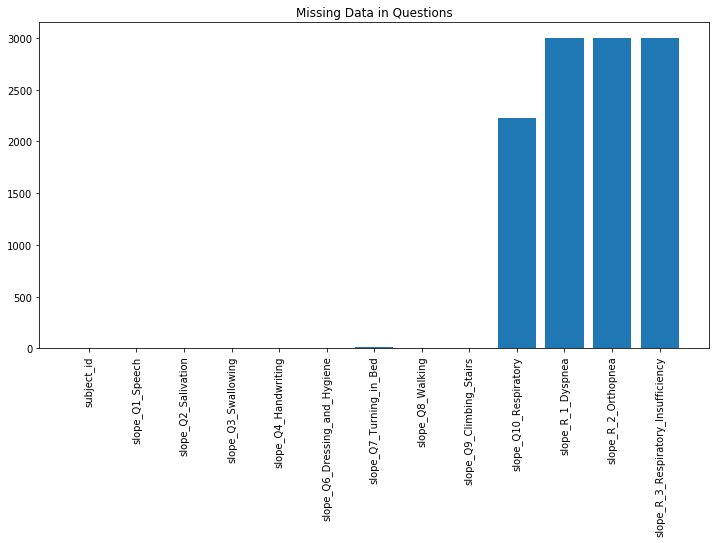

In [100]:
# number missing:
# missing columns in df
missing=[]
for col in list(questions.columns):
    missing.append(sum(questions[col].isna()))
x = np.arange(len(list(questions.columns)))
plt.figure(figsize=(12,6))
plt.bar(x=x, height=missing)
plt.xticks(x, list(questions.columns), rotation='vertical')
plt.title("Missing Data in Questions")
plt.show()

In [101]:
# merge the questions with df
df = df.merge(questions, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10546, 80)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_R_1_Dyspnea,slope_R_2_Orthopnea,slope_R_3_Respiratory_Insufficiency
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,-0.000048,-0.000646,-0.000738,-0.000702,-0.001059,-0.001521,-0.00054,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.000000,0.000419,-0.002331,-0.002549,-0.001873,-0.003319,NaN,0.0,0.0,0.0
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Death buckets

In [24]:
death_buckets = pd.read_csv("clean_data/death_buckets.csv")
print(death_buckets.shape)
death_buckets.head()

(6868, 12)


,subject_id,died_1,died_2,died_3,died_4,died_5,died_6,died_7,died_8,died_9,died_10,died_greater_10
0,329,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,348,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,533,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,586,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,649,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# merge death buckets with df
df = df.merge(death_buckets, how='outer', on='subject_id')
print("duplicate IDs: {}".format(sum(df['subject_id'].value_counts()>1)))
print(df.shape)
df.head()

duplicate IDs: 0
(10549, 91)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,died_2,died_3,died_4,died_5,died_6,died_7,died_8,died_9,died_10,died_greater_10
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# DF - Overview of all Features 

In [75]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       'death_month', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Caucasian', 'Race_Other', 'sex', 'age_trial_start_days',
       'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_spinal', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'sympto

In [122]:
# who is subject with 2205 as death day
df[ (df['death_day_since_onset']>2500) ]

,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,slope_R_1_Dyspnea,slope_R_2_Orthopnea,slope_R_3_Respiratory_Insufficiency
390,38617,Placebo,1.0,560.0,NaN,-2487.0,518.0,3047.0,-2088.814073,435.0,...,-0.000948,-0.001512,-0.001134,-0.000683,-0.000642,-0.001134,-0.000378,NaN,NaN,NaN
1106,114733,Active,1.0,194.0,NaN,-2638.0,1765.0,2832.0,-1873.814073,404.0,...,-0.001084,-0.001136,-0.001326,-0.001272,-0.000994,-0.001472,-0.000300,NaN,NaN,NaN
1898,193178,Active,1.0,580.0,1.0,-2052.0,NaN,2632.0,-1673.814073,376.0,...,-0.000081,-0.001362,-0.001719,-0.001720,-0.001753,-0.001753,-0.000369,NaN,NaN,NaN
3128,330221,Active,1.0,192.0,NaN,-4274.0,2708.0,4466.0,-3507.814073,638.0,...,-0.000544,-0.000059,-0.000122,-0.000031,-0.000371,-0.000423,-0.000229,NaN,NaN,NaN
4400,459159,Active,1.0,612.0,1.0,-2017.0,NaN,2629.0,-1670.814073,375.0,...,0.000000,-0.000476,-0.001295,-0.001723,-0.001902,-0.001902,-0.000560,NaN,NaN,NaN
4447,464833,Placebo,1.0,36.0,NaN,-6598.0,NaN,6634.0,-5675.814073,947.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7434,775620,Active,1.0,153.0,NaN,-4516.0,NaN,4669.0,-3710.814073,667.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8025,836560,Active,1.0,2033.0,NaN,-680.0,424.0,2713.0,-1754.814073,387.0,...,-0.000674,-0.001679,-0.001636,-0.001464,-0.000768,-0.001167,NaN,-0.000079,-0.000712,-0.000073
9084,946296,Active,1.0,354.0,NaN,-3245.0,NaN,3599.0,-2640.814073,514.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot death days

In [26]:
# limit to placebo subjects.
placebo = df[ df['Study_Arm']=='Placebo' ].copy()

/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


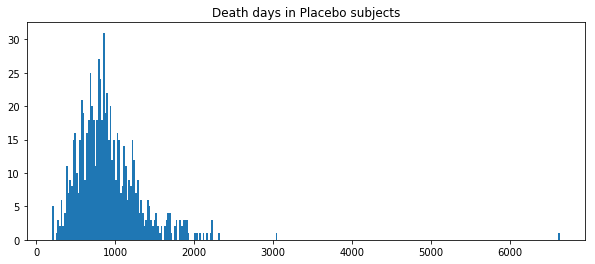

In [27]:
plt.figure(figsize=(10,4))
plt.hist(placebo['death_day_since_onset'], bins = 300)#, edgecolor="white")
plt.title('Death days in Placebo subjects')
plt.show()

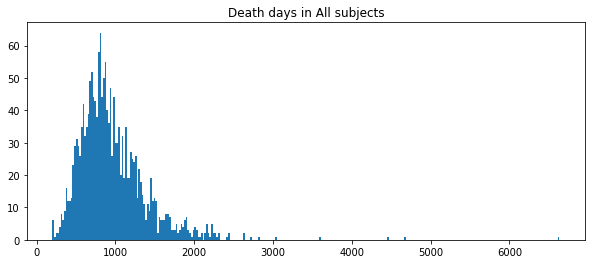

In [28]:
plt.figure(figsize=(10,4))
plt.hist(df['death_day_since_onset'], bins = 300)#, edgecolor="white")
plt.title('Death days in All subjects')
plt.show()

## Plot missing values in df

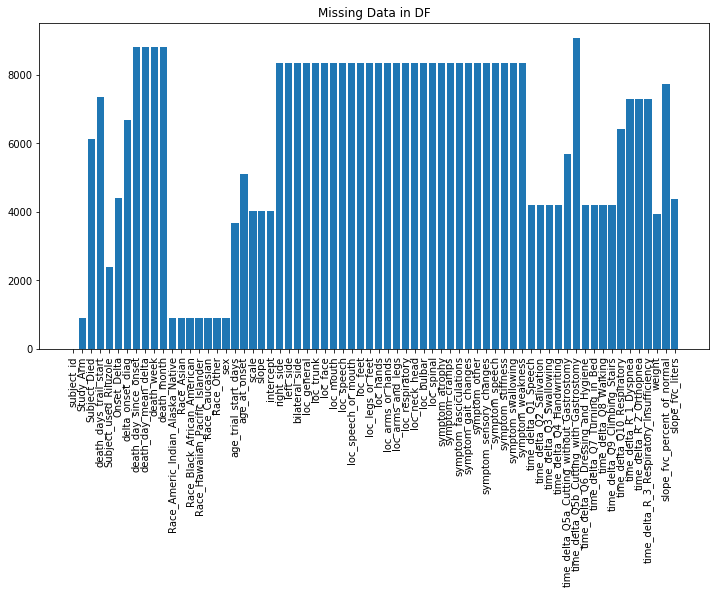

In [29]:
# missing columns in df
missing=[]
for col in list(df.columns):
    missing.append(sum(df[col].isna()))
x = np.arange(len(list(df.columns)))
plt.figure(figsize=(12,6))
plt.bar(x=x, height=missing)
plt.xticks(x, list(df.columns), rotation='vertical')
plt.title("Missing Data in DF")
plt.show()

### distribution of death days by location

In [30]:
# loc_speech_or_mouth
def plot_feature_by_death(df, col):
    print("Number of subjects: {}".format(len(df[ df[col]==1]['death_day_since_onset'])))
    plt.hist(df[ df[col]==1]['death_day_since_onset'], bins=50,
            ec="white")
    plt.title(col)
    plt.xlim(0,4000)
    plt.axvline(1800, color="red")
    plt.show()
    mean_death = df[ df[col]==1]['death_day_since_onset'].mean()
    print("mean day from onset to death = {}".format(mean_death))
    return mean_death

Number of subjects: 493


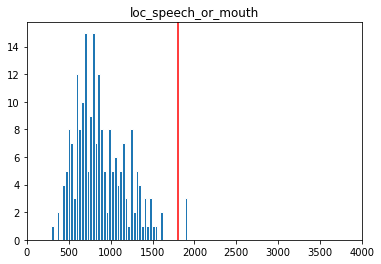

mean day from onset to death = 881.1563981042653


In [31]:
speech_mouth = plot_feature_by_death(df, 'loc_speech_or_mouth')

Number of subjects: 499


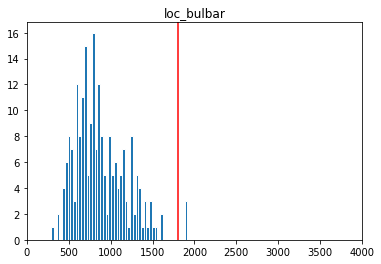

mean day from onset to death = 877.8644859813085


In [32]:
feet = plot_feature_by_death(df, 'loc_bulbar')

Number of subjects: 1775


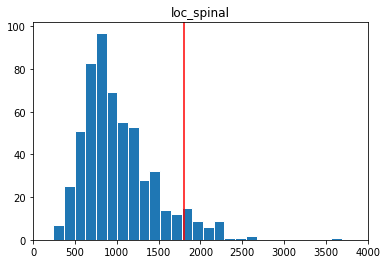

mean day from onset to death = 1037.6660839160838


In [34]:
legs_or_feet = plot_feature_by_death(df, 'loc_spinal')

Number of subjects: 83


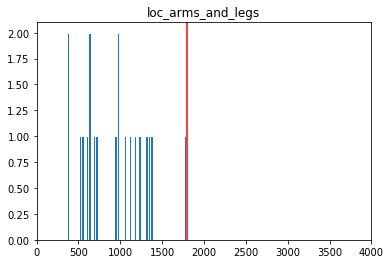

mean day from onset to death = 915.6


In [35]:
arms_and_legs = plot_feature_by_death(df, 'loc_arms_and_legs')

Number of subjects: 529


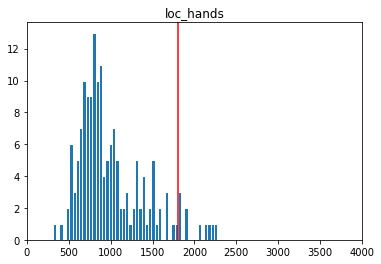

mean day from onset to death = 1003.4285714285714


In [36]:
hands = plot_feature_by_death(df, 'loc_hands')

## Make X for analysis  
- remove non-analysis features.

In [37]:
print(df.shape)
df.head()

(10546, 68)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,death_week,...,time_delta_Q7_Turning_in_Bed,time_delta_Q8_Walking,time_delta_Q9_Climbing_Stairs,time_delta_Q10_Respiratory,time_delta_R_1_Dyspnea,time_delta_R_2_Orthopnea,time_delta_R_3_Respiratory_Insufficiency,weight,slope_fvc_percent_of_normal,slope_fvc_liters
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,638.0,NaN,NaN,NaN,...,0.001010,0.001010,0.001515,0.000505,NaN,NaN,NaN,52.2,-0.002073,-0.00099
2,348,Placebo,NaN,NaN,1.0,-501.0,199.0,NaN,NaN,NaN,...,0.002217,0.002217,0.003326,NaN,0.0,0.0,0.0,118.8,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       'death_month', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Caucasian', 'Race_Other', 'sex', 'age_trial_start_days',
       'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_spinal', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'sympto

In [39]:
# columns not the include
drop_demo = ['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
        'Onset_Delta', 'Diagnosis_Delta', 'delta_onset_diag']
drop_weight = ['weight']
drop_age = ['age_at_onset']
drop_death = ['death_day_mean_delta', 'death_week', 'death_month']
drop_race = ['Ethnicity', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
             'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
              'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify']
drop_other = ['scale', 'intercept']
drop_questions = ['time_delta_Q1_Speech', 'time_delta_Q2_Salivation', 
        'time_delta_Q3_Swallowing',
       'time_delta_Q4_Handwriting',
       'time_delta_Q5a_Cutting_without_Gastrostomy',
       'time_delta_Q5b_Cutting_with_Gastrostomy',
       'time_delta_Q6_Dressing_and_Hygiene', 'time_delta_Q7_Turning_in_Bed',
       'time_delta_Q8_Walking', 'time_delta_Q9_Climbing_Stairs',
       'time_delta_Q10_Respiratory', 'time_delta_R_1_Dyspnea',
       'time_delta_R_2_Orthopnea', 'time_delta_R_3_Respiratory_Insufficiency']
drop_fvc = ['slope_fvc_percent_of_normal']

In [43]:
data_to_include = ['death_day_since_onset', 'Subject_used_Riluzole', 
                   'Race_Caucasian', 'sex', 'age_at_onset', 'slope', 
                   'right_side', 'left_side', 'bilateral_side', 'loc_bulbar', 
                   'loc_spinal', 'weight',
                   'slope_fvc_liters']

In [45]:
# select the features to include in model.
pre_model_data = df[data_to_include].copy()
print(pre_model_data.shape)
pre_model_data.head()

(10546, 13)


,death_day_since_onset,Subject_used_Riluzole,Race_Caucasian,sex,age_at_onset,slope,right_side,left_side,bilateral_side,loc_bulbar,loc_spinal,weight,slope_fvc_liters
0,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.0,0.0,42.673973,-0.007092,NaN,NaN,NaN,NaN,NaN,52.2,-0.00099
2,NaN,1.0,1.0,0.0,53.372603,-0.012720,NaN,NaN,NaN,NaN,NaN,118.8,NaN
3,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Model Data

In [46]:
model_data = pre_model_data.copy()
print(model_data.shape)
model_data.head()

(10546, 13)


,death_day_since_onset,Subject_used_Riluzole,Race_Caucasian,sex,age_at_onset,slope,right_side,left_side,bilateral_side,loc_bulbar,loc_spinal,weight,slope_fvc_liters
0,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.0,0.0,42.673973,-0.007092,NaN,NaN,NaN,NaN,NaN,52.2,-0.00099
2,NaN,1.0,1.0,0.0,53.372603,-0.012720,NaN,NaN,NaN,NaN,NaN,118.8,NaN
3,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot missing values

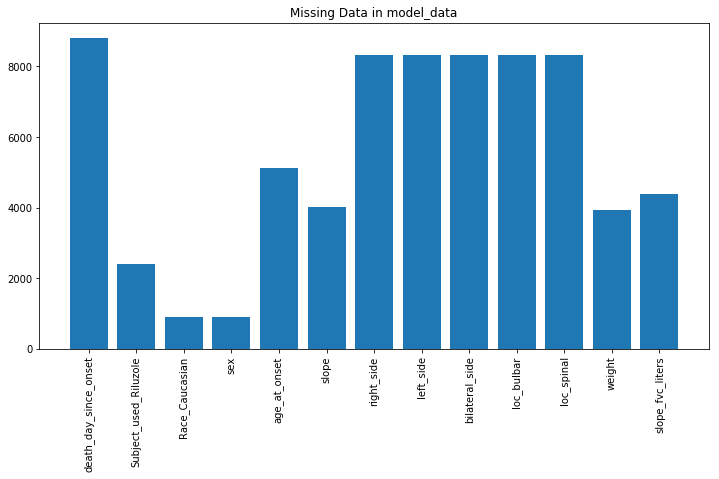

In [47]:
# missing columns in model_data
missing=[]
for col in list(pre_model_data.columns):
    missing.append(sum(pre_model_data[col].isna()))
x = np.arange(len(list(pre_model_data.columns)))
plt.figure(figsize=(12,6))
plt.bar(x=x, height=missing)
plt.xticks(x, list(pre_model_data.columns), rotation='vertical')
plt.title("Missing Data in model_data")
plt.show()

## Plot individual features of the data

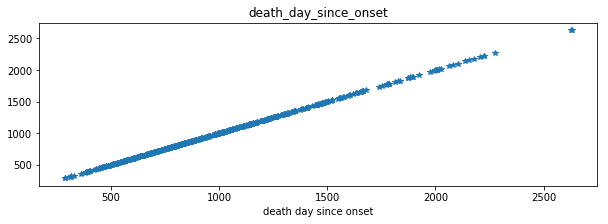

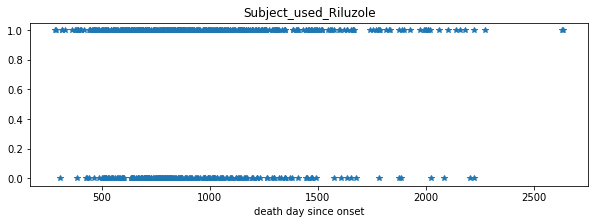

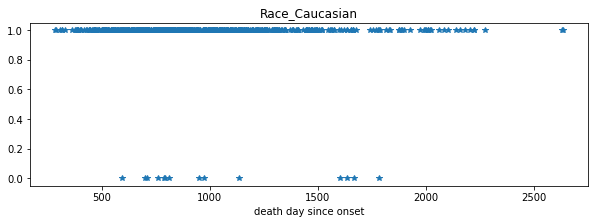

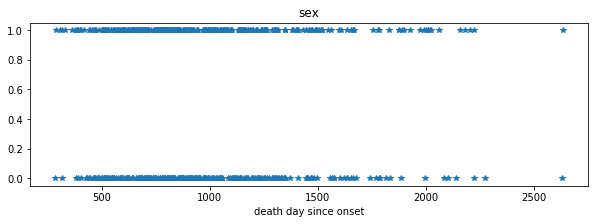

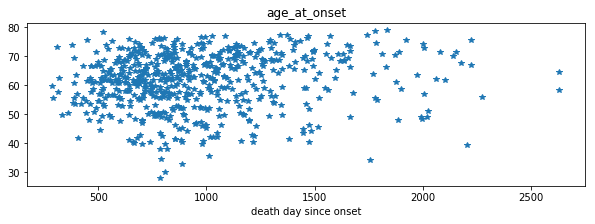

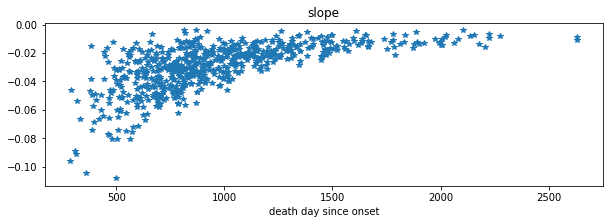

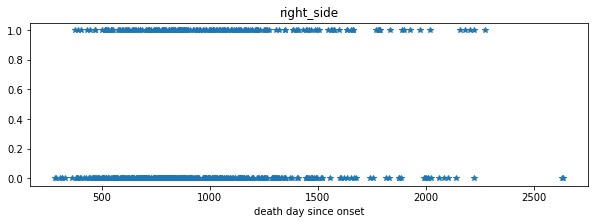

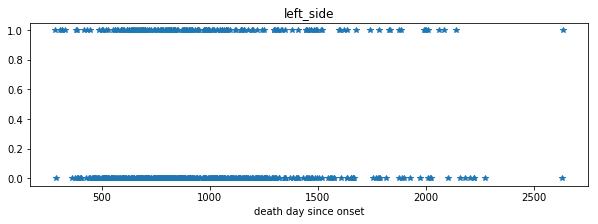

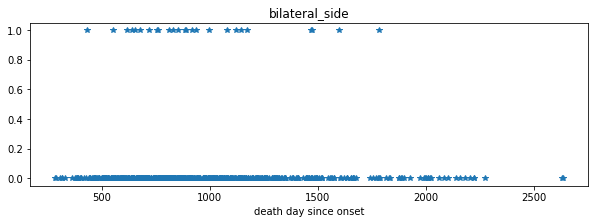

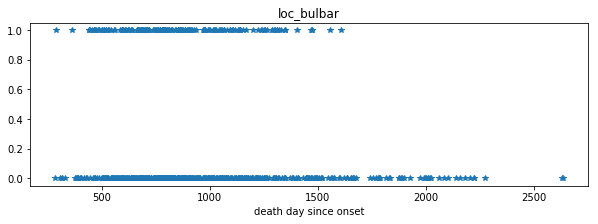

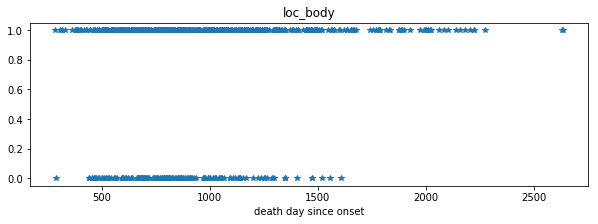

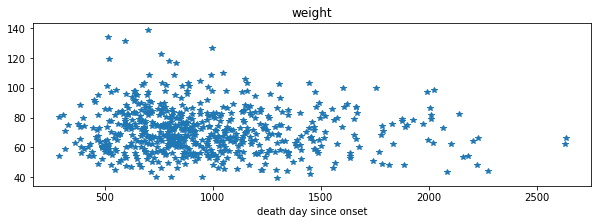

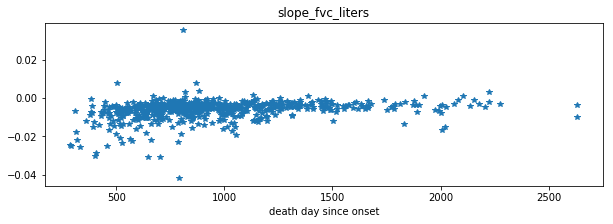

In [204]:
for feat in list(model_data.columns):
    plt.figure(figsize=(10,3))
    #sns.jointplot(X3['death_day_since_onset'], X3[feat] , kind='scatter')
    plt.plot( model_data['death_day_since_onset'], model_data[feat],'*')
    plt.title(feat)
    plt.xlabel("death day since onset")
    plt.show()

## Linear Model

In [167]:
params = {'a':1}
lm = Linear_Model('linear', X, y, params)

/Users/Shared/galvanize/als/regress_model.py:233: RuntimeWarning: invalid value encountered in log
  self.rmse_log = np.sqrt(((( np.log(self.predicted+1)-np.log(self.y_train + 1) )**2).sum() ) / len(self.y_train))


In [168]:
lm.rmse

291.88771630785067

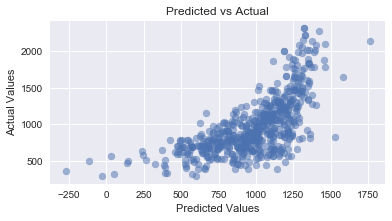

In [169]:
lm_plot(lm.predicted, lm.y_train)

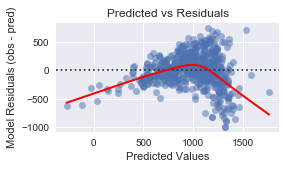

In [170]:
resid_plot(lm.predicted, lm.resid)

## Cluster analysis

In [115]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'Diagnosis_Delta',
       'delta_onset_diag', 'death_day_since_onset', 'death_day_mean_delta',
       'death_week', 'death_month', 'Ethnicity',
       'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify',
       'sex', 'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_body', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 's

In [95]:
# features to include:
features = [ 'Subject_used_Riluzole', 'death_day_since_onset', 'Race_Caucasian', 
       'sex', 'age_at_onset', 'slope', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'symptom_atrophy', 
        'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'symptom_swallowing', 'symptom_weakness',
       'weight']

potential = ['loc_bulbar', 'loc_body', 'slope_fvc_percent_of_normal']

# pick a limited number of columns from df
cluster_X = df[features].copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(653, 33)


,Subject_used_Riluzole,death_day_since_onset,Race_Caucasian,sex,age_at_onset,slope,right_side,left_side,bilateral_side,loc_general,...,symptom_cramps,symptom_fasciculations,symptom_gait_changes,symptom_other,symptom_sensory_changes,symptom_speech,symptom_stiffness,symptom_swallowing,symptom_weakness,weight
0,1.0,405.0,1.0,1.0,41.808219,-0.053054,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,74.3
1,1.0,624.0,1.0,0.0,61.191781,-0.037167,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,46.7
2,0.0,825.0,1.0,0.0,70.263014,-0.011764,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.7
3,1.0,585.0,1.0,1.0,68.887671,-0.025766,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,75.0
4,1.0,656.0,1.0,1.0,71.295890,-0.012011,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,89.0


In [96]:
cluster_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 33 columns):
Subject_used_Riluzole      653 non-null float64
death_day_since_onset      653 non-null float64
Race_Caucasian             653 non-null float64
sex                        653 non-null float64
age_at_onset               653 non-null float64
slope                      653 non-null float64
right_side                 653 non-null float64
left_side                  653 non-null float64
bilateral_side             653 non-null float64
loc_general                653 non-null float64
loc_trunk                  653 non-null float64
loc_face                   653 non-null float64
loc_mouth                  653 non-null float64
loc_speech                 653 non-null float64
loc_speech_or_mouth        653 non-null float64
loc_feet                   653 non-null float64
loc_legs_or_feet           653 non-null float64
loc_hands                  653 non-null float64
loc_arms_or_hands          653 

### Cluster Functions

In [144]:
def cluster(df, params):
    k=KMeans(**params).fit(df)
    result = pd.DataFrame(k.labels_, columns=["kmeans_label"])
    cluster_result = pd.concat([cluster_X, result], axis=1)
    return cluster_result

In [145]:
# plot the labels for each feature
def plot_cluster(df):
    plt.figure(figsize=(12,6))
    for col in list(df.columns):
        plt.scatter(cluster_result['death_day_since_onset'], cluster_result[col], 
                    c=cluster_result['kmeans_label'])
        plt.title(col)
        plt.show()

### cluster weight

In [112]:
# cluster weight
cluster_X = df[['weight', 'death_day_since_onset']].copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(1637, 2)


,weight,death_day_since_onset
0,63.8,1320.0
1,74.3,405.0
2,46.7,624.0
3,62.7,825.0
4,73.6,292.0


In [137]:
params = {'n_clusters':2, 'init':'k-means++', 'n_init':10, 'max_iter':300, 
          'tol':0.0001, 'precompute_distances':'auto', 'verbose':0, 
          'random_state':None, 'copy_x':True, 'n_jobs':None, 'algorithm':'auto'}
cluster_result = cluster(cluster_X, params)
plot_cluster(cluster_result)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### cluster function slope

In [168]:
# cluster weight
cluster_X = df[['slope', 'death_day_since_onset']].copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(1643, 2)


,slope,death_day_since_onset
0,-0.006526,1320.0
1,-0.053054,405.0
2,-0.037167,624.0
3,-0.011764,825.0
4,-0.071534,292.0


In [169]:
# transform the negative slope
cluster_X['slope_transform'] = (cluster_X['slope'] + 1 - min(cluster_X['slope']))

In [170]:
cluster_X.head()

,slope,death_day_since_onset,slope_transform
0,-0.006526,1320.0,1.143430
1,-0.053054,405.0,1.096902
2,-0.037167,624.0,1.112789
3,-0.011764,825.0,1.138192
4,-0.071534,292.0,1.078423


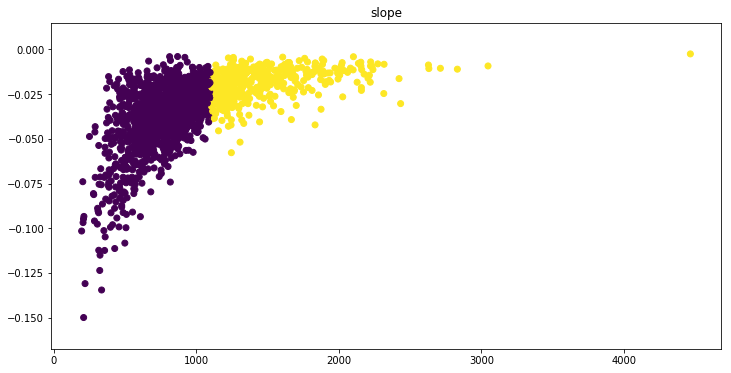

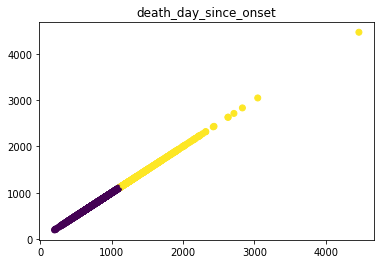

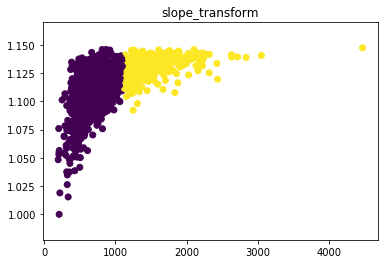

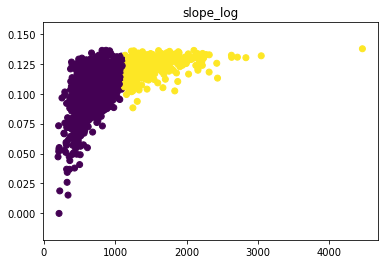

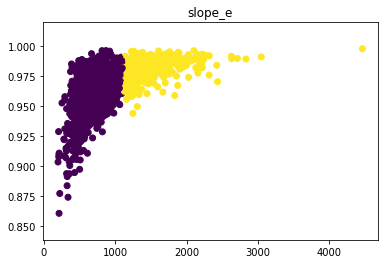

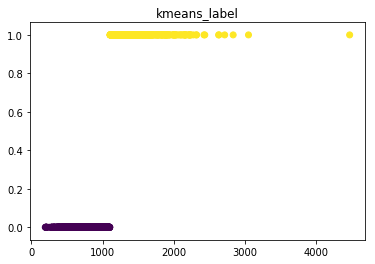

In [167]:
params = {'n_clusters':2, 'init':'k-means++', 'n_init':10, 'max_iter':300, 
          'tol':0.0001, 'precompute_distances':'auto', 'verbose':0, 
          'random_state':None, 'copy_x':True, 'n_jobs':None, 'algorithm':'auto'}
cluster_result = cluster(cluster_X, params)
plot_cluster(cluster_result)

### cluster buckets

In [118]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'Diagnosis_Delta',
       'delta_onset_diag', 'death_day_since_onset', 'death_day_mean_delta',
       'death_week', 'death_month', 'Ethnicity',
       'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify',
       'sex', 'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_body', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 's

In [119]:
# cluster buckets
buckets = df.merge(death_buckets, how='outer',on='subject_id')
buckets.head()

,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,delta_onset_diag,death_day_since_onset,death_day_mean_delta,...,died_2,died_3,died_4,died_5,died_6,died_7,died_8,died_9,died_10,died_greater_10
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,638.0,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,199.0,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
cluster_X = df[['slope', 'death_day_since_onset']].copy()
cluster_X.dropna(axis=0, inplace=True)
cluster_X.reset_index(drop=True, inplace=True)
print(cluster_X.shape)
cluster_X.head()

(1643, 2)


,slope,death_day_since_onset
0,-0.006526,1320.0
1,-0.053054,405.0
2,-0.037167,624.0
3,-0.011764,825.0
4,-0.071534,292.0


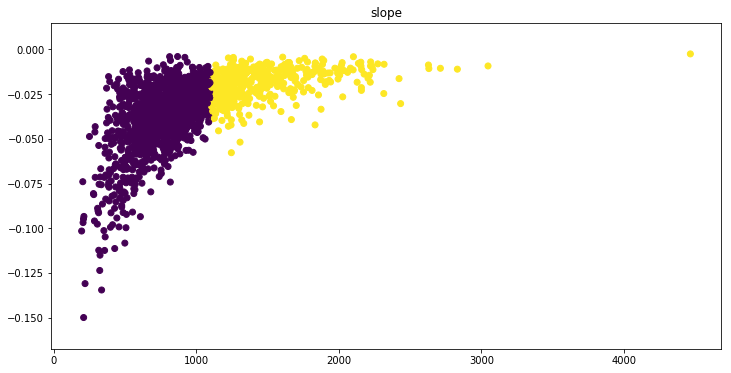

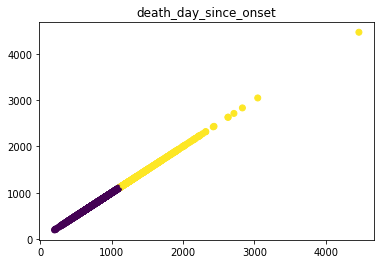

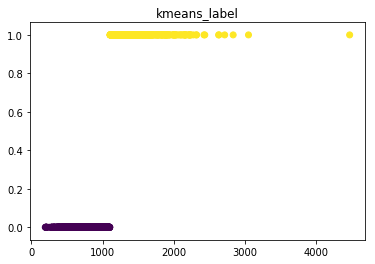

In [110]:
cluster_result = cluster(cluster_X)
plot_cluster(cluster_result)

In [ ]:
death_buckets

# Random Forest Regressor

## Predict death day: all features

In [102]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       'death_month', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Caucasian', 'Race_Other', 'sex', 'age_trial_start_days',
       'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_spinal', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'sympto

** Comparison Data **
Number of training observations: 486
Number of test observations: 162
     test  predicted  result
0  1177.0     1232.1  result
1   600.0      654.8  result
2   521.0      671.5  result
3   957.0      811.6  result
4   620.0      537.5  result

Accuracy/R2 Score: 0.7200960392521456


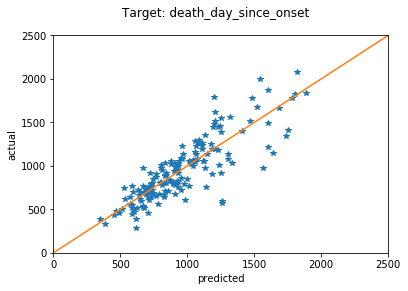

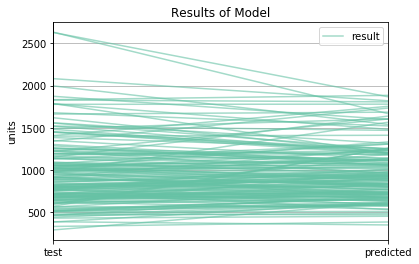

Permutation Feature Importance


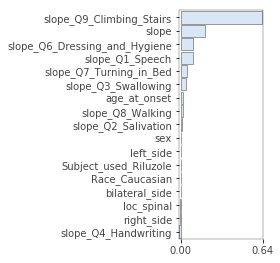

In [121]:
# limit to: none
# run RF on day to death
this_data = df.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'

features = ['death_day_since_onset', 'Subject_used_Riluzole', 
            'Race_Caucasian', 'sex', 'age_at_onset', 'slope', 
            'right_side', 'left_side', 'bilateral_side', 'loc_bulbar', 
            'loc_spinal', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
       'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs']

# limit on: None of feature name
limit_on = None 

# exclude: None, string, or list
exclude_columns = ['loc_bulbar']

run_rf(df=this_data, features=features, class_regress=class_regress, 
       target=target, limit_on=limit_on, exclude_columns=exclude_columns)

# Gradient Boost Regressor

## Predict death day: all features

In [142]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       'death_month', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Caucasian', 'Race_Other', 'sex', 'age_trial_start_days',
       'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_spinal', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'sympto

** Comparison Data **
Number of training observations: 486
Number of test observations: 162
     test    predicted  result
0  1177.0  1249.131263  result
1   600.0   722.778109  result
2   521.0   754.465172  result
3   957.0   980.031308  result
4   620.0   690.429784  result

Accuracy/R2 Score: 0.7406008507663203


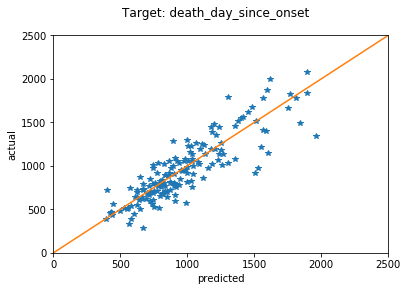

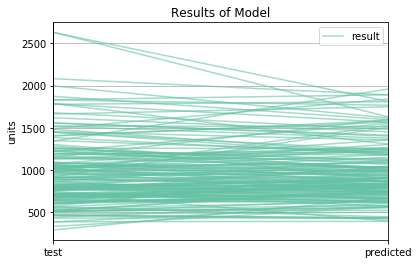

Permutation Feature Importance


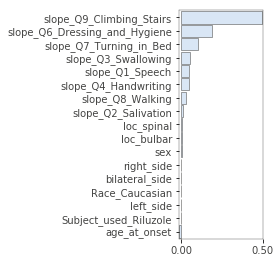

In [180]:
# limit to: none
# run gboost on day to death
this_data = df.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'

features = ['death_day_since_onset', 'Subject_used_Riluzole', 
            'Race_Caucasian', 'sex', 'age_at_onset', 'slope', 
            'right_side', 'left_side', 'bilateral_side', 'loc_bulbar', 
            'loc_spinal', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
       'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs']

# limit on: None of feature name
limit_on = None 

# exclude: None, string, or list
exclude_columns = ['slope']

# set model params
params = {'learning_rate': 0.1, 'max_features': 4, 'min_samples_leaf': 4, 
          'min_samples_split': 10, 'n_estimators': 150}

run_gboost(this_data, features, class_regress, target, limit_on, exclude_columns, params)

In [179]:
# run the data with grid search
# set crossvalidation parameters
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_features': [3, 4, 5],
    'min_samples_leaf': [3, 4, 6],
    'min_samples_split': [4, 8, 10, 15],
    'n_estimators': [ 150, 200, 250, 350]
}


run_cv_gboost(df, features, class_regress, target, limit_on, exclude_columns, param_grid)


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   46.1s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  1.2min


{'learning_rate': 0.1, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}


[Parallel(n_jobs=4)]: Done 1296 out of 1296 | elapsed:  1.5min finished


## Only run regression with subjects with onset locations

In [176]:
model_data.columns

Index(['Subject_used_Riluzole', 'death_day_since_onset', 'sex', 'slope',
       'right_side', 'left_side', 'bilateral_side', 'loc_general', 'loc_trunk',
       'loc_face', 'loc_mouth', 'loc_speech', 'loc_speech_or_mouth',
       'loc_feet', 'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_body', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'symptom_swallowing', 'symptom_weakness', 'slope_fvc_liters'],
      dtype='object')

## Predict day of death using: loc_bulbar only

In [175]:
sum(model_data['loc_bulbar'])

178.0

** Comparison Data **
Number of training observations: 133
Number of test observations: 45
     test  predicted  result
0  1014.0      593.3  result
1   907.0      621.0  result
2   683.0      901.1  result
3   597.0      802.6  result
4  1028.0      714.2  result

Accuracy/R2 Score: -0.11477699966252208


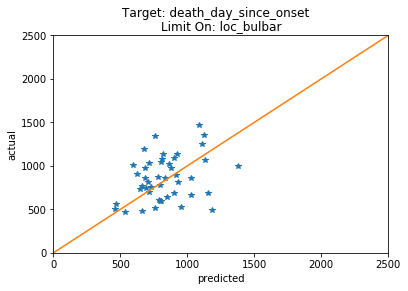

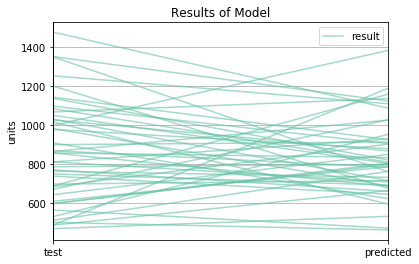

Permutation Feature Importance


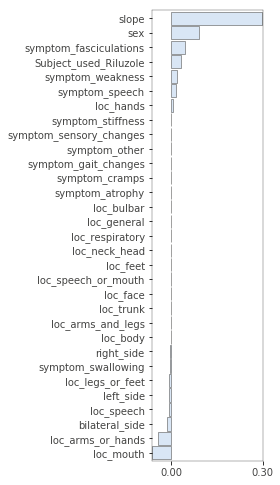

In [177]:
# limit to: loc_speech_or_mouth
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'loc_bulbar'    # None of feature name
exclude_columns = ['slope_fvc_liters']  # string or list

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

## Predict day of death using: loc_speech_or_mouth

** Comparison Data **
Number of training observations: 135
Number of test observations: 46
     test  predicted  result
0  1302.0     1153.0  result
1   691.0      500.6  result
2   707.0      550.2  result
3  1251.0      995.9  result
4   898.0      827.2  result

Accuracy/R2 Score: 0.3909694811765144


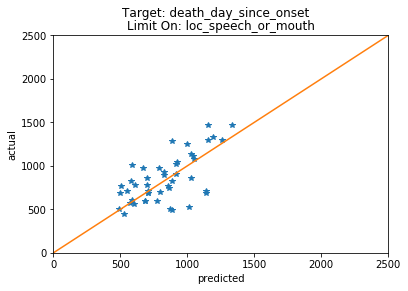

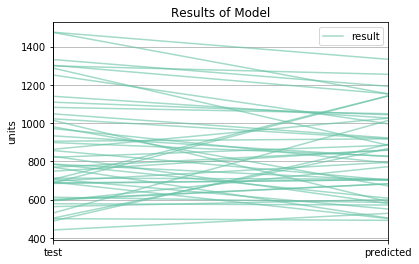

Permutation Feature Importance


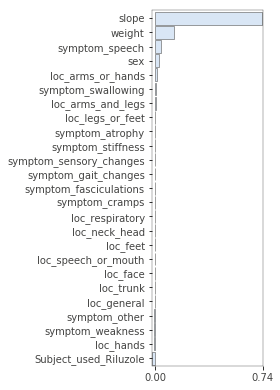

In [53]:
# limit to: loc_speech_or_mouth
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'loc_speech_or_mouth'    # None of feature name
exclude_columns = ['age_at_onset', 'loc_speech', 'loc_mouth']   # string or list

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

## Predict day of death using: loc_speech

** Comparison Data **
Number of training observations: 86
Number of test observations: 29
    test  predicted  result
0  640.0      779.6  result
1  974.0      894.5  result
2  852.0      788.1  result
3  670.0      684.0  result
4  593.0      899.5  result

Accuracy/R2 Score: 0.4353825453510335


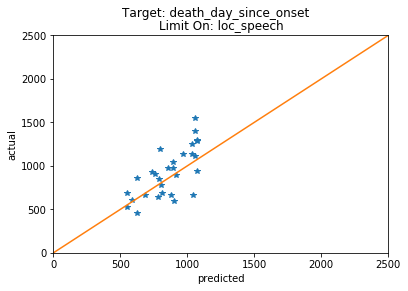

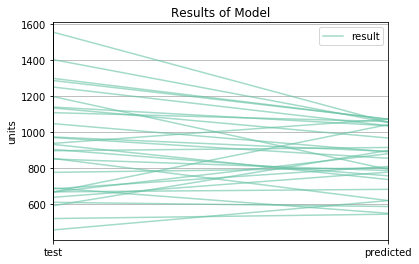

Permutation Feature Importance


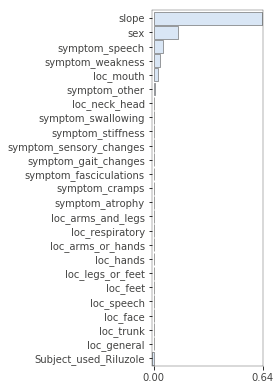

In [59]:
# limit to: loc_speech_or_mouth
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'loc_speech'    # None of feature name
exclude_columns = ['age_at_onset', 'loc_speech_or_mouth', 'weight']   # string or list

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

## Predict day of death using: Subject_used_Riluzole

** Comparison Data **
Number of training observations: 324
Number of test observations: 109
     test  predicted  result
0  1403.0     1322.7  result
1   648.0     1087.7  result
2  1754.0      930.8  result
3  1198.0      783.9  result
4   837.0      725.2  result

Accuracy/R2 Score: 0.38774173843728965


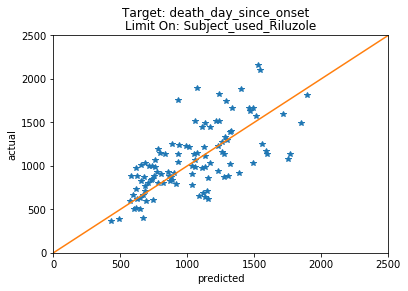

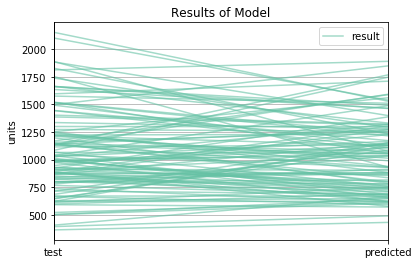

Permutation Feature Importance


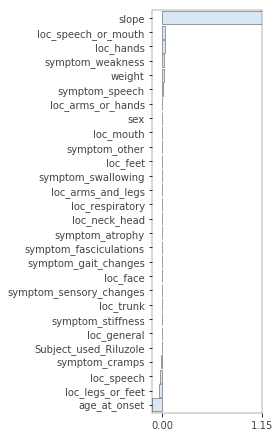

In [46]:
# limit to: Subject_used_Riluzole
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'Subject_used_Riluzole'    # None of feature name
#exclude_columns = 'slope'

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

## Predict day of death using: loc_feet

** Comparison Data **
Number of training observations: 45
Number of test observations: 16
     test  predicted  result
0  1241.0      887.0  result
1  1446.0      838.2  result
2  1177.0     1123.6  result
3   871.0     1239.7  result
4  1158.0      753.5  result

Accuracy/R2 Score: -0.5429368836039274


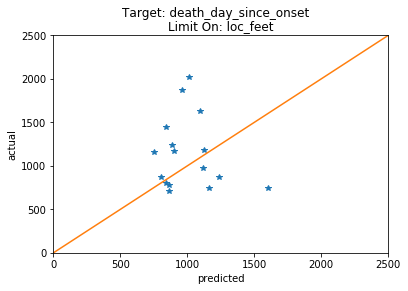

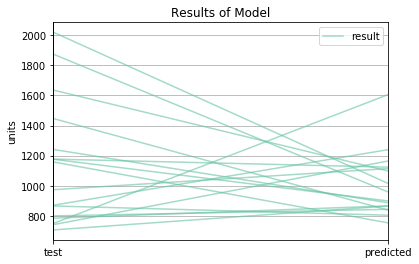

Permutation Feature Importance


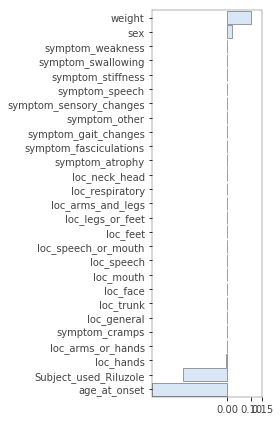

In [47]:
# limit to: loc_feet
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'loc_feet'    # None of feature name
exclude_columns = 'slope'

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

## Predict day of death using: loc_legs_or_feet

** Comparison Data **
Number of training observations: 189
Number of test observations: 64
    test  predicted  result
0  516.0      637.8  result
1  939.0      844.0  result
2  835.0     1095.5  result
3  885.0      769.7  result
4  502.0      525.6  result

Accuracy/R2 Score: 0.5369012639970279


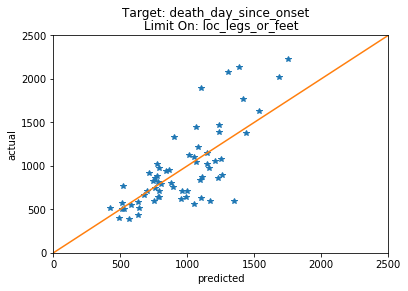

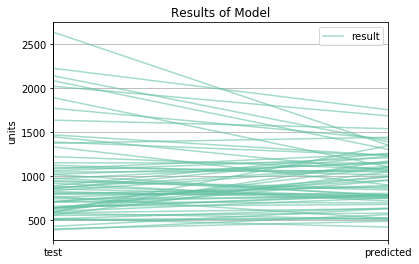

Permutation Feature Importance


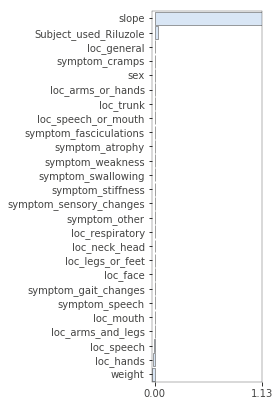

In [51]:
# limit to: loc_legs_or_feet
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'loc_legs_or_feet'    # None of feature name
exclude_columns = ['loc_feet', 'age_at_onset']

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

## Predict day of death using: symptom_speech

** Comparison Data **
Number of training observations: 78
Shape of test: (27, 3)
    test  predicted  result
0  756.0      668.8  result
1  290.0      522.6  result
2  362.0      571.5  result
3  885.0      532.1  result
4  640.0      770.8  result

Accuracy/R2 Score: 0.3458112995386462


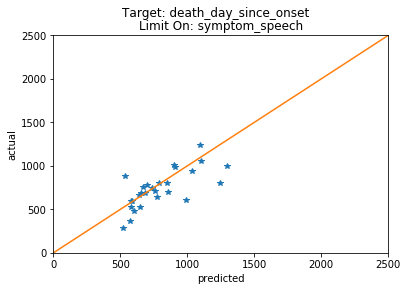

Permutation Feature Importance


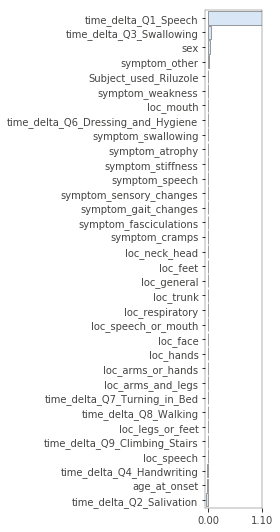

In [143]:
# limit to: symptom_speech
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'symptom_speech'    # None of feature name
#exclude_columns = 'slope'

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

In [137]:
model_data.columns

Index(['Subject_used_Riluzole', 'death_day_since_onset', 'sex', 'age_at_onset',
       'slope', 'loc_general', 'loc_trunk', 'loc_face', 'loc_mouth',
       'loc_speech', 'loc_speech_or_mouth', 'loc_feet', 'loc_legs_or_feet',
       'loc_hands', 'loc_arms_or_hands', 'loc_arms_and_legs',
       'loc_respiratory', 'loc_neck_head', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'symptom_swallowing', 'symptom_weakness', 'time_delta_Q1_Speech',
       'time_delta_Q2_Salivation', 'time_delta_Q3_Swallowing',
       'time_delta_Q4_Handwriting', 'time_delta_Q6_Dressing_and_Hygiene',
       'time_delta_Q7_Turning_in_Bed', 'time_delta_Q8_Walking',
       'time_delta_Q9_Climbing_Stairs'],
      dtype='object')

## Predict day of death using: symptom_weakness

** Comparison Data **
Number of training observations: 418
Shape of test: (140, 3)
     test  predicted  result
0   520.0      620.2  result
1   598.0      760.6  result
2   978.0      856.3  result
3   638.0      644.0  result
4  1408.0     1781.5  result

Accuracy/R2 Score: 0.7793151794365991


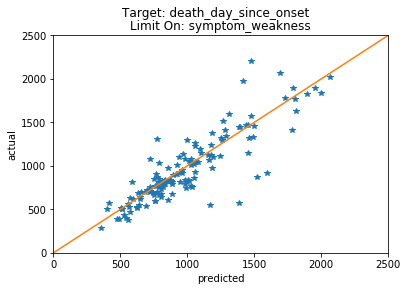

Permutation Feature Importance


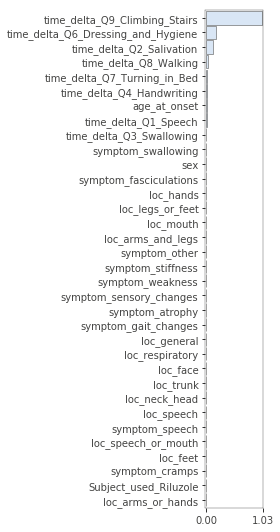

In [142]:
# limit to: symptom_weakness
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'symptom_weakness'    # None of feature name
exclude_columns = 'slope'

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

## Predict day of death using: loc_hands

** Comparison Data **
Number of training observations: 111
Shape of test: (37, 3)
     test  predicted  result
0  1564.0     1398.0  result
1   519.0      634.7  result
2  1312.0     1556.5  result
3  1498.0     1918.2  result
4   864.0      898.8  result

Accuracy/R2 Score: 0.6782941620093093


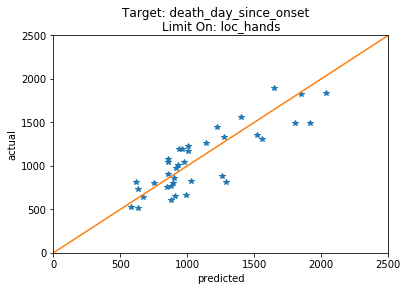

Permutation Feature Importance


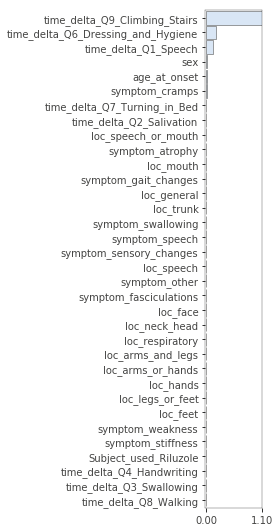

In [141]:
# limit to: loc_hands
# run RF on day to death
this_data = model_data.copy()
class_regress = 'regression'    # regression or classifier

# targets, limits
target = 'death_day_since_onset'
limit_on = 'loc_hands'    # None of feature name
exclude_columns = 'slope'

run_rf(this_data, class_regress, target, limit_on, exclude_columns)

# Random Forest Classifier

## Predict death year bucket: all features

In [125]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'delta_onset_diag',
       'death_day_since_onset', 'death_day_mean_delta', 'death_week',
       'death_month', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Caucasian', 'Race_Other', 'sex', 'age_trial_start_days',
       'age_at_onset', 'scale', 'slope', 'intercept', 'right_side',
       'left_side', 'bilateral_side', 'loc_general', 'loc_trunk', 'loc_face',
       'loc_mouth', 'loc_speech', 'loc_speech_or_mouth', 'loc_feet',
       'loc_legs_or_feet', 'loc_hands', 'loc_arms_or_hands',
       'loc_arms_and_legs', 'loc_respiratory', 'loc_neck_head', 'loc_bulbar',
       'loc_spinal', 'symptom_atrophy', 'symptom_cramps',
       'symptom_fasciculations', 'symptom_gait_changes', 'symptom_other',
       'symptom_sensory_changes', 'symptom_speech', 'symptom_stiffness',
       'sympto

** Comparison Data **
Number of training observations: 409
Number of test observations: 137
   test  predicted  result
0   1.0        1.0  result
1   0.0        0.0  result
2   0.0        0.0  result
3   0.0        0.0  result
4   1.0        1.0  result

Accuracy/R2 Score: 0.9197080291970803
Cross Val Scores: [0.8902439  0.96341463 0.90243902 0.90243902 0.88888889]
Mean Cross Val Score: 0.9094850948509485
** Confusion Matrix **
                Actual      
                  True False
Predicted True      10     0
          False     11   116

** F1 Score **
F1 = 2 * (precision * recall) / (precision + recall)
F1 Score: 64.52%


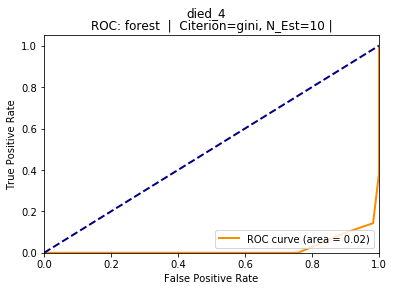

Permutation Feature Importance


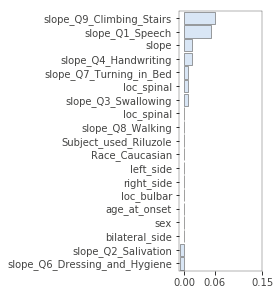

In [139]:
# limit to: none
# run RF on day to death
this_data = df.copy()
class_regress = 'classifier'    # regression or classifier

# targets, limits
target = 'died_4'

# include the target
features = ['died_4', 'Subject_used_Riluzole', 'Race_Caucasian', 'sex', 'age_at_onset', 
            'slope', 'loc_bulbar', 'loc_spinal',
            'right_side', 'left_side', 'bilateral_side',
            'loc_spinal', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
            'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
            'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs']

# limit on: None of feature name
limit_on = None 

# exclude: None, string, or list
exclude_columns = None

run_rf(df=this_data, features=features, class_regress=class_regress, 
       target=target, limit_on=limit_on, exclude_columns=exclude_columns)

# Plotting Model Stuff

In [106]:
import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Scatterpolar(
  r = [39, 28, 8, 7, 28, 39],
  theta = ['A','B','C', 'D', 'E', 'A'],
  fill = 'toself'
)]

layout = go.Layout(
  polar = dict(
    radialaxis = dict(
      visible = True,
      range = [0, 50]
    )
  ),
  showlegend = False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "radar/basic")

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.